<a href="https://colab.research.google.com/github/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/blob/main/7%20Model%20Selection%20and%20Feature%20Importance2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model Selection**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install openpyxl -q
import openpyxl
import pickle

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# CatBoost
!pip install catboost -q
from catboost import CatBoostRegressor, Pool
# XGBoost
import xgboost as xgb
from xgboost import XGBRegressor
# RandomForest
from sklearn.ensemble import RandomForestRegressor
# Linear Regression+l1 Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
# AdaBoost
from sklearn.ensemble import AdaBoostRegressor
# LightGBM
import lightgbm as lgb

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

!pip -qq install category_encoders
from category_encoders import TargetEncoder

# Set display options
%matplotlib inline
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 1000)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 187.4 kB/s eta 0:00:00


In [ ]:
# apartments = pd.read_excel('https://raw.githubusercontent.com/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/main/apartments_5.xlsx', engine='openpyxl')

In [9]:
# import pickle

!wget https://github.com/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/raw/main/apartments5.pkl -q

with open('apartments5.pkl', 'rb') as f:
    apartments = pickle.load(f)

Drop notinformative columns and make Encodin

In [10]:
apartments.drop(columns=['Host Since','First Review', 'Last Review','Reviews', 'Latitude_Bin', 'Longitude_Bin', 'Latitude_Bin2', 'Longitude_Bi2n','Listing ID'], inplace=True)

apartments['Is Superhost'] = apartments['Is Superhost'].replace({'t': 1, 'f': 0}).fillna(0).astype(int)
apartments['Instant Bookable'] = apartments['Instant Bookable'].replace({'t': 1, 'f': 0}).fillna(0).astype(int)
apartments['Is Exact Location'] = apartments['Is Exact Location'].replace({'t': 1, 'f': 0}).fillna(0).astype(int)

# apartments['Host Response Time'] = apartments['Host Response Time'].replace(
#     {'within an hour':0, 'within a few hours': 1, 'within a day': 2, 'a few days or more': 3 }).fillna(3).astype(int)


# Model Selection and feature importance

In [6]:
# Convert non-numeric columns to categorical
non_numeric_columns = apartments.select_dtypes(exclude=['number']).columns
apartments[non_numeric_columns] = apartments[non_numeric_columns].astype('category')

In [11]:
X = apartments.drop(columns=['Price', 'Price Log'])
y = apartments['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=179)

# Identify categorical and numerical features
cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = X_train.select_dtypes(include=['number']).columns.tolist()

# Preprocessor for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Заполнение пропусков средним значением для числовых данных
            ('scaler', StandardScaler())
        ]), num_features),

        ('cat_onehot', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Заполнение пропусков для категориальных данных
            ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
        ]), cat_features)
    ])

# Function to get feature names after One-Hot Encoding
def get_feature_names_onehot(preprocessor, cat_features, num_features):
    # Обучаем препроцессор на тренировочных данных
    preprocessor.fit(X_train)

    # Get the names of the new categorical features
    ohe_feature_names = preprocessor.named_transformers_['cat_onehot'].named_steps['onehot'].get_feature_names_out(cat_features)

    # Combine numerical and categorical feature names
    all_feature_names = np.concatenate([num_features, ohe_feature_names])

    return all_feature_names

# Full pipeline for One-Hot Encoding
onehot_full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Lasso())
])

# Pipeline for Target Encoding (categorical variables are processed separately)
targetenc_pipeline = Pipeline(steps=[
    ('target_enc', TargetEncoder(min_samples_leaf=10, handle_missing='value', handle_unknown='value'))
])

# Full pipeline for Target Encoding
targetenc_full_pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),  # Заполнение пропусков средним значением для числовых данных
                ('scaler', StandardScaler())
            ]), num_features),

            ('cat_targetenc', targetenc_pipeline, cat_features)
        ])),
    ('model', Lasso())
])

# List of models to be evaluated
models = {
    'Lasso': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(silent=True, random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# Function to train the model and collect metrics
def evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name, feature_names, encoding_method):
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    metrics = {
        'Model': model_name,
        'Encoding Method': encoding_method,
        'Train MSE': mean_squared_error(y_train, y_train_pred),
        'Test MSE': mean_squared_error(y_test, y_test_pred),
        'Train R2': r2_score(y_train, y_train_pred),
        'Test R2': r2_score(y_test, y_test_pred)
    }

    # Extract feature importances
    if model_name == 'Lasso':
        feature_importances = np.abs(pipeline.named_steps['model'].coef_)
    else:
        feature_importances = pipeline.named_steps['model'].feature_importances_

    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    return metrics, feature_importance_df

# Tables to store metrics and feature importances
metrics_table = pd.DataFrame()
feature_importance_onehot = pd.DataFrame()
feature_importance_targetenc = pd.DataFrame()

# Evaluate models with One-Hot Encoding
for model_name, model in models.items():
    onehot_full_pipeline.set_params(model=model)
    all_feature_names = get_feature_names_onehot(preprocessor, cat_features, num_features)

    metrics, feature_importances = evaluate_model(onehot_full_pipeline, X_train, X_test, y_train, y_test, model_name, all_feature_names, 'One-Hot Encoding')
    metrics_table = pd.concat([metrics_table, pd.DataFrame([metrics])], ignore_index=True)
    feature_importance_onehot = pd.concat([feature_importance_onehot, feature_importances.rename(columns={'Importance': model_name +'OH'})], axis=1)

# Evaluate models with Target Encoding
for model_name, model in models.items():
    targetenc_full_pipeline.set_params(model=model)
    all_feature_names = np.concatenate([num_features, cat_features])

    metrics, feature_importances = evaluate_model(targetenc_full_pipeline, X_train, X_test, y_train, y_test, model_name, all_feature_names, 'Target Encoding')
    metrics_table = pd.concat([metrics_table, pd.DataFrame([metrics])], ignore_index=True)
    feature_importance_targetenc = pd.concat([feature_importance_targetenc, feature_importances.rename(columns={'Importance': model_name +'TE'})], axis=1)

# Save metrics and feature importances to CSV files
metrics_table.to_csv('model_metrics.csv', index=False)
feature_importance_onehot.to_csv('feature_importance_onehot.csv', index=False)
feature_importance_targetenc.to_csv('feature_importance_targetenc.csv', index=False)

# Display metrics and feature importances
# print(metrics_table)
# print("Feature Importance with One-Hot Encoding:")
# print(feature_importance_onehot)
# print("Feature Importance with Target Encoding:")
# print(feature_importance_targetenc)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4320
[LightGBM] [Info] Number of data points in the train set: 17067, number of used features: 689
[LightGBM] [Info] Start training from score 59.431242
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 17067, number of used features: 37
[LightGBM] [Info] Start training from score 59.431242


In [12]:
metrics_table

,Model,Encoding Method,Train MSE,Test MSE,Train R2,Test R2
0,Lasso,One-Hot Encoding,861.895284,910.751417,0.490528,0.487882
1,Random Forest,One-Hot Encoding,104.179068,767.344462,0.938419,0.568520
2,CatBoost,One-Hot Encoding,483.371024,712.855296,0.714276,0.599160
3,LightGBM,One-Hot Encoding,475.013847,709.443220,0.719216,0.601078
4,XGBoost,One-Hot Encoding,390.255208,743.552077,0.769317,0.581899
5,Lasso,Target Encoding,729.132934,896.441917,0.569004,0.495928
6,Random Forest,Target Encoding,89.948693,827.836450,0.946831,0.534505
7,CatBoost,Target Encoding,332.153160,748.274951,0.803662,0.579243
8,LightGBM,Target Encoding,402.066143,775.790310,0.762336,0.563771
9,XGBoost,Target Encoding,222.951902,814.867418,0.868212,0.541798


In [23]:
feature_importance_targetenc

,Feature,LassoTE,Feature,Random ForestTE,Feature,CatBoostTE,Feature,LightGBMTE,Feature,XGBoostTE
0,Accomodates,7.977850,Accomodates,0.239644,Bin-Bin,16.941570,Bin-Bin,368,Room Type,0.187120
1,Bedrooms,6.525504,Bin-Bin,0.184718,Room Type,11.229411,Distance_from_center,206,Bedrooms,0.181440
2,Guests Included,3.479515,Room Type,0.082293,Accomodates,9.757867,Host Since Years,188,Accomodates,0.150305
3,Bathrooms,2.200681,Bedrooms,0.057767,Bedrooms,7.986266,Accomodates,153,Bathrooms,0.082714
4,Distance_from_center,1.811544,Distance_from_center,0.037462,Property Type,6.270901,Last Review Years,137,Bin-Bin,0.063376
5,Reviews Log,1.135017,Property Type,0.032654,Distance_from_center,4.415477,First Review Years,133,Property Type,0.048680
6,Cleanliness Rating,1.107516,Host Since Years,0.031872,Guests Included,3.690434,Property Type,127,Guests Included,0.026580
7,Bin-Bin,1.075110,Longitude,0.026830,Bathrooms,3.181323,Bin2-Bin2,123,Host Response Time,0.023062
8,Is Rating,0.640316,Latitude,0.024802,Host Since Years,3.024065,Longitude,120,Distance_from_center,0.015919
9,Property Type,0.552072,Bin2-Bin2,0.023012,Bin2-Bin2,2.495301,Min Nights,97,Value Rating,0.011954


# Ranks feature importances for different models

In [15]:
feature_importance_onehot2 = feature_importance_onehot.copy()
for i in range(feature_importance_onehot.shape[0]):
    for j in apartments.columns:
        if j in feature_importance_onehot.iloc[i,0]:
            feature_importance_onehot.iloc[i,0] = j
        if j in feature_importance_onehot.iloc[i,2]:
            feature_importance_onehot.iloc[i,2] = j
        if j in feature_importance_onehot.iloc[i,4]:
            feature_importance_onehot.iloc[i,4] = j
        if j in feature_importance_onehot.iloc[i,6]:
            feature_importance_onehot.iloc[i,6] = j
        if j in feature_importance_onehot.iloc[i,8]:
            feature_importance_onehot.iloc[i,8] = j

In [18]:
lasso_imp = feature_importance_onehot.iloc[:,1].groupby(feature_importance_onehot.iloc[:,0]).sum().sort_values(ascending=False)
forest_imp = feature_importance_onehot.iloc[:,3].groupby(feature_importance_onehot.iloc[:,2]).sum().sort_values(ascending=False)
CatB_imp = feature_importance_onehot.iloc[:,5].groupby(feature_importance_onehot.iloc[:,4]).sum().sort_values(ascending=False)
lGBM_imp = feature_importance_onehot.iloc[:,7].groupby(feature_importance_onehot.iloc[:,6]).sum().sort_values(ascending=False)
XGB_imp = feature_importance_onehot.iloc[:,9].groupby(feature_importance_onehot.iloc[:,8]).sum().sort_values(ascending=False)

lasso_impTE = feature_importance_targetenc.iloc[:,1].groupby(feature_importance_targetenc.iloc[:,0]).sum().sort_values(ascending=False)
forest_impTE = feature_importance_targetenc.iloc[:,3].groupby(feature_importance_targetenc.iloc[:,2]).sum().sort_values(ascending=False)
CatB_impTE = feature_importance_targetenc.iloc[:,5].groupby(feature_importance_targetenc.iloc[:,4]).sum().sort_values(ascending=False)
lGBM_impTE = feature_importance_targetenc.iloc[:,7].groupby(feature_importance_targetenc.iloc[:,6]).sum().sort_values(ascending=False)
XGB_impTE = feature_importance_targetenc.iloc[:,9].groupby(feature_importance_targetenc.iloc[:,8]).sum().sort_values(ascending=False)

merged_imp = pd.merge(lasso_imp, forest_imp, left_on='Feature', right_on='Feature', how='left')
merged_imp = pd.merge(merged_imp, CatB_imp, left_on='Feature', right_on='Feature', how='left')
merged_imp = pd.merge(merged_imp, lGBM_imp, left_on='Feature', right_on='Feature', how='left')
merged_imp = pd.merge(merged_imp, XGB_imp, left_on='Feature', right_on='Feature', how='left')

merged_imp = pd.merge(merged_imp, lasso_impTE, left_on='Feature', right_on='Feature', how='left')
merged_imp = pd.merge(merged_imp, forest_impTE, left_on='Feature', right_on='Feature', how='left')
merged_imp = pd.merge(merged_imp, CatB_impTE, left_on='Feature', right_on='Feature', how='left')
merged_imp = pd.merge(merged_imp, lGBM_impTE, left_on='Feature', right_on='Feature', how='left')
merged_imp = pd.merge(merged_imp, XGB_impTE, left_on='Feature', right_on='Feature', how='left')

merged_imp['Lasso RankOH'] = merged_imp['LassoOH'].rank(ascending=False)
merged_imp['Random Forest RankOH'] = merged_imp['Random ForestOH'].rank(ascending=False)
merged_imp['CatBoost RankOH'] = merged_imp['CatBoostOH'].rank(ascending=False)
merged_imp['LightGBM RankOH'] = merged_imp['LightGBMOH'].rank(ascending=False)
merged_imp['XGBoost RankOH'] = merged_imp['XGBoostOH'].rank(ascending=False)

merged_imp['Lasso RankTE'] = merged_imp['LassoTE'].rank(ascending=False)
merged_imp['Random Forest RankTE'] = merged_imp['Random ForestTE'].rank(ascending=False)
merged_imp['CatBoost RankTE'] = merged_imp['CatBoostTE'].rank(ascending=False)
merged_imp['LightGBM RankTE'] = merged_imp['LightGBMTE'].rank(ascending=False)
merged_imp['XGBoost RankTE'] = merged_imp['XGBoostTE'].rank(ascending=False)

merged_imp

,LassoOH,Random ForestOH,CatBoostOH,LightGBMOH,XGBoostOH,LassoTE,Random ForestTE,CatBoostTE,LightGBMTE,XGBoostTE,Lasso RankOH,Random Forest RankOH,CatBoost RankOH,LightGBM RankOH,XGBoost RankOH,Lasso RankTE,Random Forest RankTE,CatBoost RankTE,LightGBM RankTE,XGBoost RankTE
Feature,,,,,,,,,,,,,,,,,,,,
Room Type,17.779973,0.086117,17.445819,75,0.061990,0.480117,0.082293,11.229411,62,0.187120,1.0,3.0,1.0,17.0,7.0,12.0,3.0,2.0,21.0,1.0
Accomodates,9.915272,0.252623,11.653899,157,0.031473,7.977850,0.239644,9.757867,153,0.150305,2.0,1.0,2.0,6.0,9.0,1.0,1.0,3.0,4.0,3.0
Bedrooms,7.548731,0.067200,7.850283,73,0.062713,6.525504,0.057767,7.986266,70,0.181440,3.0,4.0,4.0,19.0,6.0,2.0,4.0,4.0,19.0,2.0
Property Type,5.386940,0.039793,9.037668,174,0.125550,0.552072,0.032654,6.270901,127,0.048680,4.0,6.0,3.0,4.0,3.0,10.0,6.0,5.0,7.0,6.0
Guests Included,4.359589,0.019164,5.316806,96,0.007351,3.479515,0.016766,3.690434,93,0.026580,5.0,15.0,7.0,13.0,12.0,3.0,14.0,7.0,12.0,7.0
neighbourhood,4.328941,0.024199,3.652604,109,0.071561,0.080812,0.008339,0.834886,59,0.008303,6.0,13.0,8.0,11.0,5.0,17.0,25.0,28.0,22.0,22.0
Distance_from_center,3.887257,0.039347,5.470648,202,0.006388,1.811544,0.037462,4.415477,206,0.015919,7.0,7.0,6.0,1.0,13.0,5.0,5.0,6.0,2.0,9.0
Bathrooms,2.909744,0.038333,5.920817,43,0.028889,2.200681,0.021001,3.181323,50,0.082714,8.0,8.0,5.0,27.0,10.0,4.0,11.0,8.0,25.0,4.0
Host Response Time,2.370156,0.010163,3.328106,60,0.016538,0.380791,0.008375,1.359948,52,0.023062,9.0,23.0,10.0,23.5,11.0,13.0,24.0,24.0,24.0,8.0


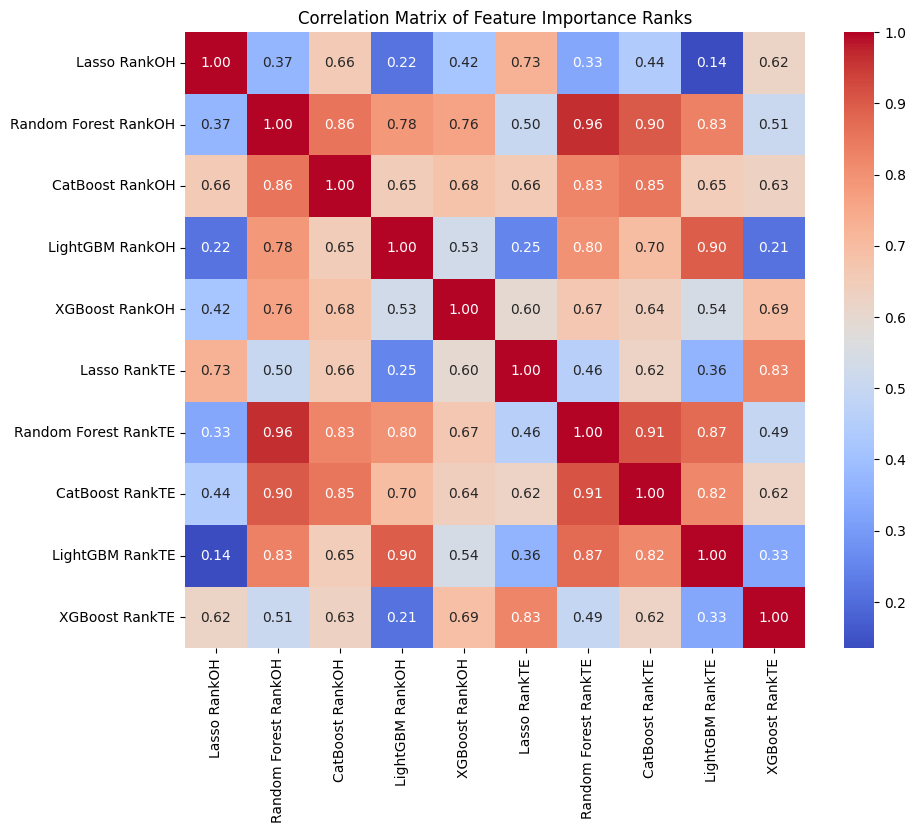

In [ ]:
# Выберите столбцы для корреляции
rank_columns = ['Lasso RankOH', 'Random Forest RankOH', 'CatBoost RankOH',
       'LightGBM RankOH', 'XGBoost RankOH', 'Lasso RankTE',
       'Random Forest RankTE', 'CatBoost RankTE', 'LightGBM RankTE',
       'XGBoost RankTE']

# Вычислите корреляционную матрицу
correlation_matrix = merged_imp[rank_columns].corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Feature Importance Ranks')
plt.show()


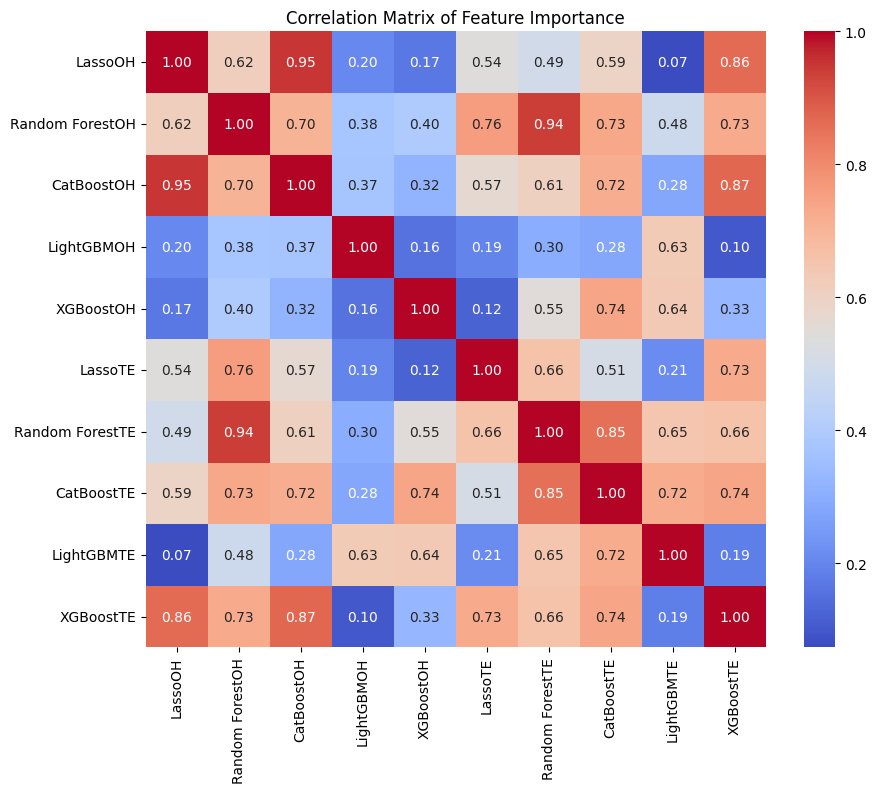

In [22]:
# # Выберите столбцы для корреляции
# no_rank_columns = ['LassoOH', 'Random ForestOH', 'CatBoostOH',
#        'LightGBMOH', 'XGBoostOH', 'LassoTE',
#        'Random ForestTE', 'CatBoostTE', 'LightGBMTE',
#        'XGBoostTE']

# # Вычислите корреляционную матрицу
# correlation_matrix = merged_imp[no_rank_columns].corr()

# # Визуализация корреляционной матрицы
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('Correlation Matrix of Feature Importance')
# plt.show()

In [ ]:
# apartments.to_excel('apartments_5.xlsx', index=False)
# import pickle

with open('apartments6.pkl', 'wb') as f:
    pickle.dump(apartments, f)
